<a href="https://colab.research.google.com/github/iharshmgoyal/Twitter_Combat_Hate_Speech_Project/blob/main/Twitter_Combat_Hate_Speech_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Libraries

import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
import string
from string import punctuation
import itertools # Helps to convert all lists into one single big list.
import unidecode # Helps in Removing unicode characters from tweets.
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_score

nltk.download('stopwords')
stop_words = stopwords.words('english')
tk = TweetTokenizer()
counter = Counter()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1. Load the tweets file using read_csv function from Pandas package.

In [2]:
data = pd.read_csv('Twitter.csv')

In [3]:
data['tweet'] = data['tweet'].apply(lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()]))

In [4]:
data.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation


In [5]:
data.shape

(31962, 3)

2. Get the tweets into a list for easy text cleanup and manipulation.

In [6]:
tweets = list(data['tweet'].values)
print(type(tweets))
tweets[:10]

<class 'list'>


['@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run',
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked",
 'bihday your majesty',
 '#model i love u take with u all the time in urd+-!!! dddd d|d|d|',
 'factsguide: society now #motivation',
 '[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo',
 '@user camping tomorrow @user @user @user @user @user @user @user dannya|',
 "the next school year is the year for exams.d- can't think about that d #school #exams #hate #imagine #actorslife #revolutionschool #girl",
 'we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers a|',
 "@user @user welcome here ! i'm it's so #gr8 !"]

3. To cleanup: 

- Normalize the casing.
- Using regular expressions, remove user handles. These begin with '@’.
- Using regular expressions, remove URLs.
- Using TweetTokenizer from NLTK, tokenize the tweets into individual terms.
- Remove stop words.
- Remove redundant terms like ‘amp’, ‘rt’, etc.
- Remove ‘#’ symbols from the tweet while retaining the term.

4. Extra cleanup by removing terms with a length of 1.

In [7]:
for i in range(len(tweets)):
    tweets[i] = tweets[i].lower()
    tweets[i] = re.sub('@', '', tweets[i])
    tweets[i] = re.sub('@user', '', tweets[i])
    tweets[i] = re.sub('rt', '', tweets[i])
    tweets[i] = re.sub('amp', '', tweets[i])
    tweets[i] = re.sub('#', '', tweets[i])
    tweets[i] = re.sub('user', '', tweets[i])
    tweets[i] = re.sub('\...', '', tweets[i])
    tweets[i] = re.sub('\d*', '', tweets[i])
    tweets[i] = re.sub('h(m)+', '', tweets[i])
    tweets[i] = re.sub(r'\b\w{1,2}\b', '', tweets[i])
    tweets[i] = tk.tokenize(tweets[i])

In [8]:
to_change = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food'} ## Need a huge dictionary

In [9]:
for i in range(len(tweets)):
    tweets[i] = [words for words in tweets[i] if words not in stop_words and words not in punctuation]
    if i in to_change:
      tweets[i] = to_change[i]
type(tweets)
tweets[:5]

[['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunctionun'],
 ['thanks',
  'lyft',
  'credit',
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdxisapointed',
  'getthanked'],
 ['bihday', 'majesty'],
 ['model', 'love', 'take', 'time', 'urd', 'dddd'],
 ['factsguide', 'society', 'motivation']]

5. Check out the top terms in the tweets:
- First, get all the tokenized terms into one large list.
- Use the counter and find the 10 most common terms.

In [10]:
new_list = list(itertools.chain.from_iterable(tweets))

In [11]:
new_list[:5]

['father', 'dysfunctional', 'selfish', 'drags', 'kids']

In [12]:
counter.most_common(10)

[]

In [13]:
tweets[:5]

[['father', 'dysfunctional', 'selfish', 'drags', 'kids', 'dysfunctionun'],
 ['thanks',
  'lyft',
  'credit',
  'use',
  'cause',
  'offer',
  'wheelchair',
  'vans',
  'pdxisapointed',
  'getthanked'],
 ['bihday', 'majesty'],
 ['model', 'love', 'take', 'time', 'urd', 'dddd'],
 ['factsguide', 'society', 'motivation']]

6. Data formatting for predictive modeling:

- Join the tokens back to form strings. This will be required for the vectorizers.
- Assign x and y.
- Perform train_test_split using sklearn.

In [14]:
for i in range(len(tweets)):
  tweets[i] = ' '.join(tweets[i])

In [15]:
tweets[:5]

['father dysfunctional selfish drags kids dysfunctionun',
 'thanks lyft credit use cause offer wheelchair vans pdxisapointed getthanked',
 'bihday majesty',
 'model love take time urd dddd',
 'factsguide society motivation']

In [16]:
data['tweet'] = pd.DataFrame(tweets)

In [17]:
data.head()

,id,label,tweet
0,1,0,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks lyft credit use cause offer wheelchair ...
2,3,0,bihday majesty
3,4,0,model love take time urd dddd
4,5,0,factsguide society motivation


In [18]:
data.shape

(31962, 3)

In [19]:
data['tweet'].shape

(31962,)

In [20]:
features = data['tweet']
target = data['label']
print(features.shape)
print(target.shape)

(31962,)
(31962,)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state=0, shuffle = True, stratify=data['label'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(22373,)
(9589,)
(22373,)
(9589,)


7. We’ll use TF-IDF values for the terms as a feature to get into a vector space model.

- Import TF-IDF  vectorizer from sklearn.
- Instantiate with a maximum of 5000 terms in your vocabulary.
- Fit and apply on the train set.
- Apply on the test set.

In [22]:
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.90, min_df=2,stop_words='english')

In [23]:
x_train_vect = vectorizer.fit_transform(x_train)
x_test_vect = vectorizer.fit_transform(x_test)
y = data.loc[:,'label'].values

In [24]:
rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted     0    1
Actual              
0          8885   31
1           342  331
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8916
           1       0.91      0.49      0.64       673

    accuracy                           0.96      9589
   macro avg       0.94      0.74      0.81      9589
weighted avg       0.96      0.96      0.96      9589



8. Model building: Ordinary Logistic Regression
- Instantiate Logistic Regression from sklearn with default parameters.
- Fit into  the train data.
- Make predictions for the train and the test set.

9. Model evaluation: Accuracy, recall, and f_1 score.
- Report the accuracy on the train set.
- Report the recall on the train set: decent, high, or low.
- Get the f1 score on the train set.

In [25]:
model = LogisticRegression().fit(x_train_vect, y_train)

In [26]:
y_pred_logreg = model.predict(x_test_vect)
print(pd.crosstab(y_test,y_pred_logreg,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred_logreg))

Predicted     0  1
Actual            
0          8912  4
1           673  0
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      8916
           1       0.00      0.00      0.00       673

    accuracy                           0.93      9589
   macro avg       0.46      0.50      0.48      9589
weighted avg       0.86      0.93      0.90      9589



In [27]:
Counter(y_train)

Counter({0: 20804, 1: 1569})

In [28]:
Counter(y_test)

Counter({0: 8916, 1: 673})

In [29]:
Counter(data['label'])

Counter({0: 29720, 1: 2242})

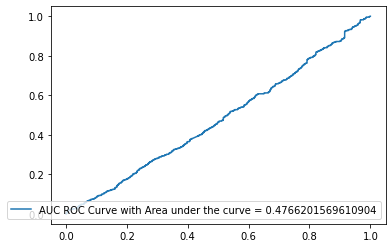

In [30]:
def generate_auc_roc_curve(clf, x_test):
  y_pred_proba = clf.predict_proba(x_test_vect)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr, tpr, label = "AUC ROC Curve with Area under the curve = "+str(auc))
  plt.legend(loc=4)
  plt.show()
  pass

generate_auc_roc_curve(model, x_test)

10. Looks like you need to adjust the class imbalance, as the model seems to focus on the 0s.
- Adjust the appropriate class in the LogisticRegression model.

In [31]:
unique_classes = target.unique()

out_dict = {}
for classes in unique_classes:
  out_dict[classes] = data.shape[0]/((data.loc[data['label'] == classes].shape[0])*len(unique_classes))

In [32]:
out_dict

{0: 0.5377187079407806, 1: 7.128010704727921}

11. Train again with the adjustment and evaluate.
- Train the model on the train set.
- Evaluate the predictions on the train set: accuracy, recall, and f_1 score.

In [33]:
clf = LogisticRegression(class_weight='balanced').fit(x_train_vect, y_train)

In [34]:
y_test_pred = clf.predict(x_test_vect)

In [35]:
print(pd.crosstab(y_test,y_test_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_test_pred))

Predicted     0     1
Actual               
0          7661  1255
1           597    76
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      8916
           1       0.06      0.11      0.08       673

    accuracy                           0.81      9589
   macro avg       0.49      0.49      0.48      9589
weighted avg       0.87      0.81      0.83      9589



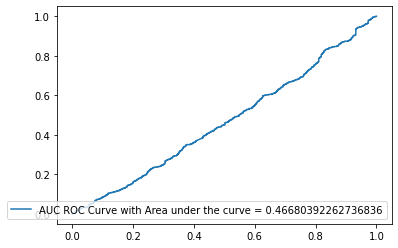

In [36]:
generate_auc_roc_curve(clf, x_test)

12. Regularization and Hyperparameter tuning:
- Import GridSearch and StratifiedKFold because of class imbalance.
- Provide the parameter grid to choose for ‘C’ and ‘penalty’ parameters.
- Use a balanced class weight while instantiating the logistic regression.

In [37]:
grid = GridSearchCV(
              estimator = LogisticRegression(class_weight='balanced', max_iter=500),
              param_grid = {'C':[0.1, 1, 10, 100, 1000], 
                            'class_weight': [{0: x, 1: 1.0-x} for x in np.linspace(0.05, 0.95, 20)]},
              cv= StratifiedKFold()
            )

grid_result = grid.fit(x_train_vect, y_train)

In [38]:
print('Best Parameters: ', grid_result.best_params_)


Best Parameters:  {'C': 10, 'class_weight': {0: 0.381578947368421, 1: 0.618421052631579}}


In [39]:
print(grid_result.best_estimator_)

LogisticRegression(C=10,
                   class_weight={0: 0.381578947368421, 1: 0.618421052631579},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


13. Find the parameters with the best recall in cross validation.
- Choose ‘recall’ as the metric for scoring.
- Choose stratified 4 fold cross validation scheme.
- Fit into  the train set.

In [40]:
model = LogisticRegression(C=10,
                   class_weight={0: 0.5377187079407806, 1: 16.128010704727921},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [41]:
model.fit(x_train_vect, y_train)

LogisticRegression(C=10,
                   class_weight={0: 0.5377187079407806, 1: 16.12801070472792},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=500, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [42]:
y_pred = model.predict(x_test_vect)

In [43]:
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted     0     1
Actual               
0          7219  1697
1           572   101
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      8916
           1       0.06      0.15      0.08       673

    accuracy                           0.76      9589
   macro avg       0.49      0.48      0.47      9589
weighted avg       0.87      0.76      0.81      9589



In [44]:
skf = StratifiedKFold(n_splits=4)

In [45]:
for i in skf.split(x_train_vect, y_train):
    print(i)

(array([ 5577,  5578,  5579, ..., 22370, 22371, 22372]), array([   0,    1,    2, ..., 5813, 5818, 5819]))
(array([    0,     1,     2, ..., 22370, 22371, 22372]), array([ 5577,  5578,  5579, ..., 11467, 11494, 11505]))
(array([    0,     1,     2, ..., 22370, 22371, 22372]), array([11160, 11161, 11162, ..., 16962, 16967, 16969]))
(array([    0,     1,     2, ..., 16962, 16967, 16969]), array([16763, 16764, 16765, ..., 22370, 22371, 22372]))


In [46]:
cross_val_score(model, x_train_vect, y_train, scoring='recall').mean()

0.7552756354164547

In [47]:
model = RandomForestClassifier(class_weight={0: 0.5377187079407806, 1: 16.128010704727921},random_state=0)

14. Best Parameters are:
  - Using LogisticRegression():
          LogisticRegression(C=10,
                   class_weight={0: 0.5377187079407806, 1: 16.12801070472792},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
  - Using RandomForestClassifier():
          RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5377187079407806,
                                     1: 16.12801070472792},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

15. Predict and evaluate using the best estimator.
- Use the best estimator from the grid search to make predictions on the test set.
- What is the recall on the test set for the toxic comments?
- What is the f_1 score?

In [48]:
model.fit(x_train_vect, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.5377187079407806,
                                     1: 16.12801070472792},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [49]:
y_pred = model.predict(x_test_vect)

In [50]:
print(pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted     0     1
Actual               
0          7111  1805
1           572   101
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      8916
           1       0.05      0.15      0.08       673

    accuracy                           0.75      9589
   macro avg       0.49      0.47      0.47      9589
weighted avg       0.86      0.75      0.80      9589



Recall on Label = 1 (Toxic Tweets) = 15%, and
F1_score = 92%